In [77]:
# imports
import os
import time

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import PIL.Image as Image
import trimesh
import torch
from torch import from_numpy, Tensor

from v_prism.utils.ui import abspath, mkdir_if_not_exists
from v_prism.utils.visualization import gen_image_of_trimesh_scene, gen_mesh_for_sdf_batch_3d
from v_prism.utils.subsample import grid_subsample, grid_subsample_different_res
from v_prism.mapping.v_prism import VPRISM
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid_for_multiple_objects
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid_multiple_objects_w_surface
from v_prism.utils.kernels import GaussianKernel
from v_prism.data_loading.negative_sampling import negative_sample_rays_in_sphere_uniform_each_step_multiclass
from v_prism.data_loading.negative_sampling import add_negative_points_below_plane
from v_prism.data_loading.negative_sampling import add_negative_points_below_plane_multiple_objects 
from v_prism.utils.ransac import robust_ransac, project_onto_plane, Plane
from v_prism.mapping.hilbert_map import HilbertMapSoftmax


In [78]:
device = torch.device("cuda")
print(f"using device: {device}")

scenes_dir = abspath("~/Documents/realsense_scenes_paper")

def create_cmap(ncolors: int):
    return {i: np.random.random(3) for i in range(1, ncolors+1)}

using device: cuda


In [79]:

height = 0.04

def entropy(map_obj, x):
    out = map_obj.predict(x.to(device)).cpu()  # (P, C)
    out = out * torch.log(out)
    out = - torch.sum(out, dim=1)
    return out

def gen_heatmap_xyz_grid(
    plane: Plane, 
    scene_center: Tensor, 
    height: float, 
    extent: float,  
    resolution: float, 
    *, 
    forward: Tensor = torch.tensor([0, 0, 1])
) -> Tensor:
    plane_no_bias = Plane(plane.normal_vect, 0.0)
    p = project_onto_plane(plane_no_bias, forward.reshape((1, 3)).to(plane_no_bias.normal_vect.dtype)).reshape(3)
    q = torch.cross(p, plane.normal_vect)
    center_proj = project_onto_plane(plane_no_bias, scene_center.reshape((1, 3))).reshape(3)
    p = p / (torch.norm(p) + 1e-9)
    q = q / (torch.norm(q) + 1e-9)
    range1 = np.arange(-extent, extent, resolution)
    L = range1.shape[0]
    ranges = [range1, -range1]
    pre_grid = torch.tensor(np.stack(np.meshgrid(*ranges), axis=-1))  # (L, L, 2)
    parallel_grid = pre_grid[:, :, 0].reshape(L, L, 1) * q + pre_grid[:, :, 1].reshape(L, L, 1) * p  # (L, L, 3)
    parallel_grid = parallel_grid + center_proj
    unit_normal_vect = plane.normal_vect / (torch.norm(plane.normal_vect) + 1e-9)
    unit_bias = plane.bias / (torch.norm(plane.normal_vect) + 1e-9)
    grid = parallel_grid + (height - unit_bias) * unit_normal_vect
    return grid  # (L, L, 3)


In [80]:
resolution = 0.01
subsample_grid_size_unocc = 0.015
subsample_grid_size_occ = 0.01
radius_for_obj = 0.3
object_sphere_radius = 0.3
scene_sphere_radius = 0.3
grid_len = 0.05
kernel_param = 750
ray_step_size = 0.1
grid_dist_from_obj = 0.15
num_surface_points = 32

view_params = {
    "theta": 0.5 * np.pi,
    "phi": 0.05 * np.pi,
    "pi": 0.95 * np.pi, 
    "rho": 0.8,
    "line_settings": {"point_size": 10}
}

def gen_reconstruction_img_for_scene(
    scene_dir, cmap
):
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    xyz_path = os.path.join(scene_dir, "xyz.npy")
    seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    # pre process points
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points = points[points_valid_mask]
    seg_mask = seg_mask[points_valid_mask]
    for id in np.unique(seg_mask[seg_mask > 0]):
        mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
        dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
        neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
        seg_mask[neg_mask] = 0

    points = from_numpy(points)
    seg_mask = from_numpy(seg_mask)
    print(f"points: {points.shape}")
    print(f"seg_mask: {seg_mask.shape}")

    start = time.time()
    hinge_points = generate_hingepoint_grid_for_multiple_objects(points, seg_mask, resolution=0.04, dist_from_obj=0.2)

    device = torch.device("cuda")

    hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
        points, seg_mask, grid_len, grid_dist_from_obj, num_surface_points
    )
    print(f"hinge_points: {hinge_points.shape}")
    kernel = GaussianKernel(kernel_param)
    # (2) create map
    vprism_map = VPRISM(
        num_classes=int(torch.amax(seg_mask).item()) + 1,
        hinge_points=hinge_points,
        kernel=kernel,
        num_iterations=3,
    ).to(device)
    # (3) neg sampling on data
    scene_center = 0.5 * (
        torch.amax(points[seg_mask > 0], dim=0) 
        + torch.amin(points[seg_mask > 0], dim=0)
    )
    X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
        points=points, 
        mask=seg_mask, 
        step_size=ray_step_size, 
        radius=object_sphere_radius,
    )
    plane = robust_ransac(points, seg_mask, 400, dist_tol=0.003, radius=scene_sphere_radius)
    X, y = add_negative_points_below_plane_multiple_objects(
        X, y, plane=[*list(plane.normal_vect), -plane.bias], center=scene_center, radius=scene_sphere_radius, k=10000
    )

    X, y = grid_subsample_different_res(
        X, 
        y, 
        subsample_grid_size_unocc=subsample_grid_size_unocc, 
        subsample_grid_size_occ=subsample_grid_size_occ
    )
    print(f"X: {X.shape}")
    # (4) fit map
    vprism_map.sequential_update(X.to(device), y.to(device), 20000)
    end = time.time()
    print(f"fit in {end - start} seconds")

    num_classes = len(seg_mask.unique())

    scene_center = 0.5 * (torch.amax(points[seg_mask > 0], dim=0) + torch.amin(points[seg_mask > 0], dim=0))
    scene_center = 0.5 * (torch.mean(points[seg_mask > 0], dim=0)) + 0.5 * scene_center

    
    heatmap_grid_xyz = gen_heatmap_xyz_grid(plane, scene_center, height=height, extent=0.3, resolution=0.003)

    L1, L2, _ = heatmap_grid_xyz.shape

    vals_entropy = entropy(vprism_map, heatmap_grid_xyz.reshape(L1 * L2, 3)).reshape(L1, L2)
    img = vals_entropy 

    return img

In [81]:
def gd_hm_recon_img(scene_dir, cmap):
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    xyz_path = os.path.join(scene_dir, "xyz.npy")
    seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    # pre process points
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points = points[points_valid_mask]
    seg_mask = seg_mask[points_valid_mask]
    for id in np.unique(seg_mask[seg_mask > 0]):
        mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
        dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
        neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
        seg_mask[neg_mask] = 0

    points = from_numpy(points)
    seg_mask = from_numpy(seg_mask)
    print(f"points: {points.shape}")
    print(f"seg_mask: {seg_mask.shape}")

    start = time.time()
    hinge_points = generate_hingepoint_grid_for_multiple_objects(points, seg_mask, resolution=0.04, dist_from_obj=0.2)


    hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
        points, seg_mask, grid_len, grid_dist_from_obj, num_surface_points
    ).to(device)
    print(f"hinge_points: {hinge_points.shape}")
    kernel = GaussianKernel(kernel_param)
    # (2) create hm
    num_classes = int(torch.amax(seg_mask).item()) + 1
    hm = HilbertMapSoftmax(
        hinge_points, 
        kernel, 
        num_classes, 
        lr=0.002,
        num_iterations=20000 
    )
    # (3) neg sampling on data
    scene_center = 0.5 * (
        torch.amax(points[seg_mask > 0], dim=0) 
        + torch.amin(points[seg_mask > 0], dim=0)
    )
    X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
        points=points, 
        mask=seg_mask, 
        step_size=ray_step_size, 
        radius=object_sphere_radius,
    )
    plane = robust_ransac(points, seg_mask, 400, dist_tol=0.003, radius=scene_sphere_radius)
    X, y = add_negative_points_below_plane_multiple_objects(
        X, y, plane=[*list(plane.normal_vect), -plane.bias], center=scene_center, radius=scene_sphere_radius, k=10000
    )

    X, y = grid_subsample_different_res(
        X, 
        y, 
        subsample_grid_size_unocc=subsample_grid_size_unocc, 
        subsample_grid_size_occ=subsample_grid_size_occ
    )
    print(f"X: {X.shape}")
    hm.update(X.to(device), y.to(device))
    num_classes = len(seg_mask.unique())

    scene_center = 0.5 * (torch.amax(points[seg_mask > 0], dim=0) + torch.amin(points[seg_mask > 0], dim=0))
    scene_center = 0.5 * (torch.mean(points[seg_mask > 0], dim=0)) + 0.5 * scene_center

    heatmap_grid_xyz = gen_heatmap_xyz_grid(plane, scene_center, height=height, extent=0.3, resolution=0.003)

    L1, L2, _ = heatmap_grid_xyz.shape

    vals_entropy = entropy(hm, heatmap_grid_xyz.reshape(L1 * L2, 3)).reshape(L1, L2)
    img = vals_entropy 

    return img

    


torch.Size([215532, 3])
Plane(normal_vect=tensor([-0.0038, -0.9951, -0.0987], dtype=torch.float64), bias=0.6693692160848831)


100%|██████████| 134/134 [00:00<00:00, 10021.87it/s]


torch.Size([215323, 3])
Plane(normal_vect=tensor([ 0.0411, -0.9973, -0.0616], dtype=torch.float64), bias=0.5936103246295651)


100%|██████████| 134/134 [00:00<00:00, 9829.94it/s]


torch.Size([215420, 3])
Plane(normal_vect=tensor([-0.0295, -0.9994, -0.0197], dtype=torch.float64), bias=0.5101897604693312)


100%|██████████| 134/134 [00:00<00:00, 10315.63it/s]


torch.Size([215515, 3])
Plane(normal_vect=tensor([ 0.0248, -0.9958, -0.0886], dtype=torch.float64), bias=0.6456035831677751)


100%|██████████| 134/134 [00:00<00:00, 9609.93it/s]


torch.Size([215256, 3])
Plane(normal_vect=tensor([-0.0159, -0.9914, -0.1298], dtype=torch.float64), bias=0.7179150632334351)


100%|██████████| 134/134 [00:00<00:00, 10919.48it/s]


points: torch.Size([215532, 3])
seg_mask: torch.Size([215532])
hinge_points: torch.Size([497, 3])
X: torch.Size([44958, 3])
iteration 50 has loss: 1.402453232389134
iteration 100 has loss: 1.2351785420161852
iteration 150 has loss: 1.1128577029020799
iteration 200 has loss: 0.9751009387720965
iteration 250 has loss: 0.860667114761705
iteration 300 has loss: 0.7322937516269915
iteration 350 has loss: 0.6513136369558434
iteration 400 has loss: 0.5966960576946112
iteration 450 has loss: 0.5305819687096294
iteration 500 has loss: 0.5130021870991193
iteration 550 has loss: 0.43594306901549273
iteration 600 has loss: 0.3875585019848055
iteration 650 has loss: 0.38541042686602345
iteration 700 has loss: 0.31749308719668007
iteration 750 has loss: 0.3075162196925276
iteration 800 has loss: 0.28723510995956836
iteration 850 has loss: 0.278800653362017
iteration 900 has loss: 0.22643798128532155
iteration 950 has loss: 0.2255131003839509
iteration 1000 has loss: 0.23079750378474587
iteration 105

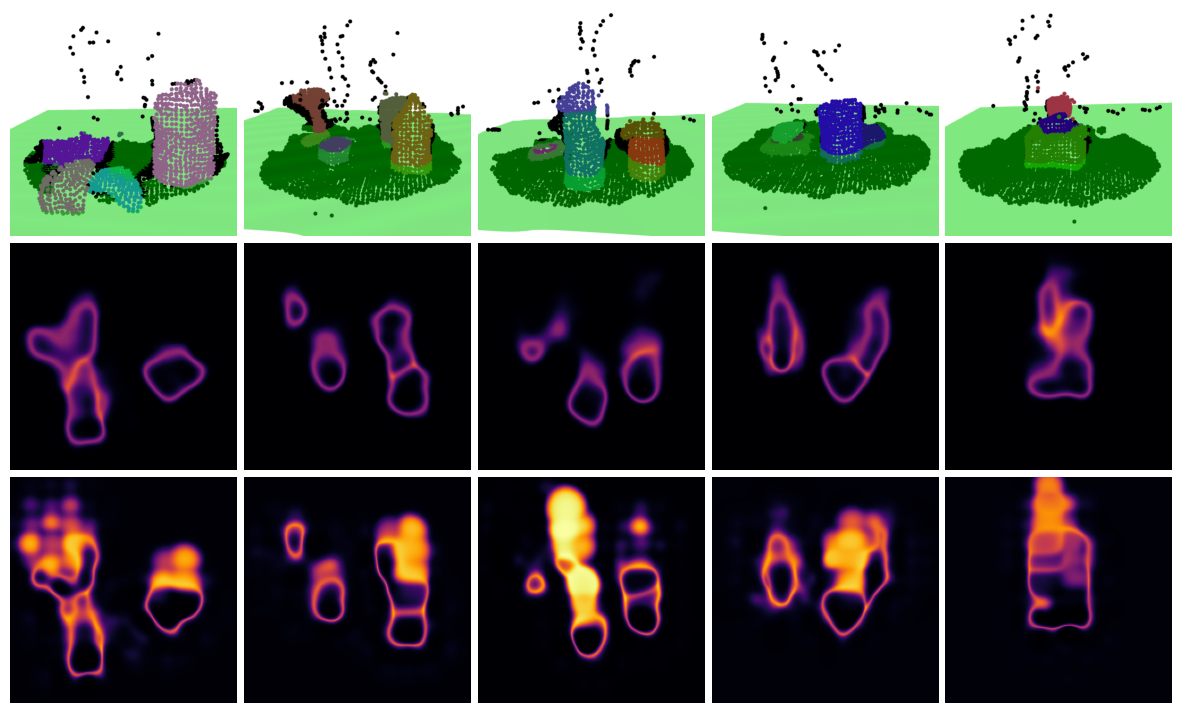

In [82]:
scene_dirs = [
    os.path.join(scenes_dir, "00000000"),
    os.path.join(scenes_dir, "00000001"),
    os.path.join(scenes_dir, "00000002"),
    os.path.join(scenes_dir, "00000004"),
    os.path.join(scenes_dir, "00000005")
]

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

plt.axis("off")
plt.subplots_adjust(wspace=0.03, hspace=0.03)

cmaps = [create_cmap(10) for i in range(5)]


for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    resolution = 0.01
    radius_for_obj = 0.3
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    xyz_path = os.path.join(scene_dir, "xyz.npy")
    seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points = points[points_valid_mask]
    seg_mask = seg_mask[points_valid_mask]
    points_torch, seg_torch = grid_subsample(from_numpy(points), from_numpy(seg_mask), resolution)
    points = points_torch.numpy()
    seg_mask = seg_torch.numpy()
    pointclouds = []
    for id in np.unique(seg_mask[seg_mask > 0]):
        mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
        dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
        mask = np.logical_and(dist_to_mean_all_pts <= radius_for_obj, seg_mask == id)
        neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
        seg_mask[neg_mask] = 0
        pc = trimesh.PointCloud(points[mask])
        pc.visual.vertex_colors = cmap[id]
        pointclouds.append(pc)
    radius = scene_sphere_radius
    scene_center = 0.5 * (np.max(points[seg_mask > 0], axis=0) + np.min(points[seg_mask > 0], axis=0))
    nearby_not_object_points = points[np.logical_and(seg_mask == 0, np.linalg.norm(points - scene_center, axis=1) <= radius)]
    pointcloud_not_obj = trimesh.PointCloud(nearby_not_object_points)

    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    # pre process points
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points_torch = from_numpy(points[points_valid_mask])
    seg_mask_torch = from_numpy(seg_mask[points_valid_mask])
    print(points_torch.shape)
    plane = robust_ransac(points_torch, seg_mask_torch, 400, dist_tol=0.01, radius=scene_sphere_radius)
    # plane.normal_vect = plane.normal_vect.to(points.dtype)
    
    plane_vect_norm = torch.norm(plane.normal_vect) + 1e-10
    plane.normal_vect = plane.normal_vect / plane_vect_norm
    plane.bias = plane.bias / plane_vect_norm
    scene_center = from_numpy(scene_center)
    print(plane)
    plane_mesh = gen_mesh_for_sdf_batch_3d(
        lambda x: (x @ plane.normal_vect.to(x.dtype) + plane.bias <= height).to(x.dtype), 
        xlim=[scene_center[0] - 0.5, scene_center[0] + 0.5], 
        ylim=[scene_center[1] - 0.5, scene_center[1] + 0.5], 
        zlim=[scene_center[2] - 0.5, scene_center[2] + 0.5], 
        resolution=0.0075,
    )

    trimesh.smoothing.filter_laplacian(plane_mesh, iterations=40)

    color = np.array([0, 1, 0, 0.5])
    plane_mesh.visual.vertex_colors = color

    mesh_img = gen_image_of_trimesh_scene(trimesh.Scene([plane_mesh, pointcloud_not_obj, *pointclouds]), **view_params, lookat_position=scene_center)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(mesh_img)

for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    mesh_img = gd_hm_recon_img(scene_dir, cmap)
    print(torch.amax(mesh_img))
    axs[1, i].set_axis_off()
    axs[1, i].imshow(mesh_img, cmap="inferno", vmin=0, vmax=1.8)

for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    mesh_img = gen_reconstruction_img_for_scene(scene_dir, cmap)
    print(torch.amax(mesh_img))

    axs[2, i].set_axis_off()
    axs[2, i].imshow(mesh_img, cmap="inferno", vmin=0, vmax=1.8)

plt.show()